# Tarea 4 - codigo

In [12]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans

# Punto 1

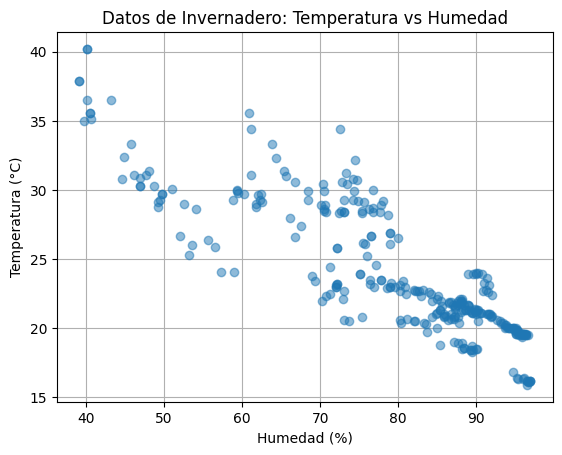

In [13]:
df_greenhouse = pd.read_csv('data/greenhouse.txt', header=None, sep='\t', names=['temperatura','humedad'])
fig, ax = plt.subplots()
ax.scatter(df_greenhouse['humedad'], df_greenhouse['temperatura'], marker='o', alpha=0.5, zorder=3)
ax.set_xlabel('Humedad (%)')
ax.set_ylabel('Temperatura (°C)')
ax.set_title('Datos de Invernadero: Temperatura vs Humedad')
ax.grid(zorder=1)
plt.show()

In [14]:
def encontrar_coefs_minimos_cuadrados(X, y):
    """Calcula los coeficientes de la regresión lineal usando el método de mínimos cuadrados.
    
    Args:
        X (np.ndarray): Matriz de características (con una columna de unos para el término independiente).
        y (np.ndarray): Vector de valores objetivo.
        
    Returns:
        np.ndarray: Vector de coeficientes.
    """
    # Cálculo de los coeficientes usando la fórmula de mínimos cuadrados

    coefs = np.linalg.inv(X.T @ X) @ X.T @ y
    return coefs

coefs = encontrar_coefs_minimos_cuadrados(
    np.column_stack((np.ones(df_greenhouse.shape[0]), df_greenhouse['humedad'])), 
    df_greenhouse['temperatura']
)
print("Coeficientes de la regresión lineal (mínimos cuadrados):", coefs)

Coeficientes de la regresión lineal (mínimos cuadrados): [46.40624409 -0.28350393]


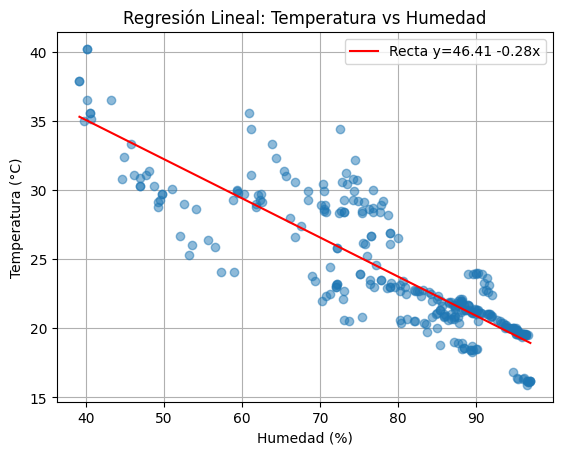

In [23]:
# graficar la línea de regresión
x_vals = np.array([df_greenhouse['humedad'].min(), df_greenhouse['humedad'].max()])
y_vals = coefs[0] + coefs[1] * x_vals
plt.scatter(df_greenhouse['humedad'], df_greenhouse['temperatura'], marker='o', alpha=0.5, zorder=3)
plt.plot(x_vals, y_vals, color='red', label='Recta y={:.2f} {:.2f}x'.format(coefs[0], coefs[1]), zorder=4)
plt.xlabel('Humedad (%)')
plt.ylabel('Temperatura (°C)')  
plt.title('Regresión Lineal: Temperatura vs Humedad')
plt.legend()
plt.grid(zorder=1)
plt.show() 

In [16]:
# función de detección de anomalías
def es_anomalo(
    X,
    hist_path="data/greenhouse.txt",
    b0=46.41, b1=-0.28,
    k=3.0,
    sep=None,
    enforce_physical=True,
    return_details=True
):
    """
    Regla: |e| > k*s, donde e = T - (b0 + b1*R) y s es el desvío residual histórico.
    X: matriz (m,2) con columnas [T, R].
    """
    # 1) lee histórico y calcula s
    data = np.loadtxt(hist_path, delimiter=sep)
    T_h, R_h = data[:,0].astype(float), data[:,1].astype(float)
    resid_h = T_h - (b0 + b1*R_h)
    s = np.sqrt(np.sum(resid_h**2) / (len(T_h) - 2))

    # 2) valida X y calcula residuos nuevos
    X = np.asarray(X, dtype=float)
    T_new, R_new = X[:,0], X[:,1]
    T_hat = b0 + b1*R_new
    e = T_new - T_hat

    # 3) umbral fijo k*s y decisión
    thr = np.full_like(e, k*s)
    is_anom = np.abs(e) > thr

    # 4) info adicional
    flags = [[] for _ in range(len(e))]
    if enforce_physical:
        for i, (Ti, Ri) in enumerate(zip(T_new, R_new)):
            if not (0.0 <= Ri <= 100.0):
                flags[i].append("R fuera de 0–100%")
            if not (-10.0 <= Ti <= 60.0):
                flags[i].append("T fuera de -10°C a 60°C")

    if not return_details:
        return is_anom

    return is_anom, {
        "T_hat": T_hat,
        "residuo_e": e,
        "s_residual": s,
        "umbral": thr,
        "k": k,
        "flags": flags
    }


In [19]:
# Leer datos nuevos y detectar anomalías
ruta = 'data/datosNuevos.txt'
df_datos_nuevos = pd.read_csv(ruta, header=None, sep=r'\s+', names=['temperatura','humedad'], engine='python')
resultados = es_anomalo(df_datos_nuevos.values)
df_datos_nuevos['es_anomalo'] = resultados[0]

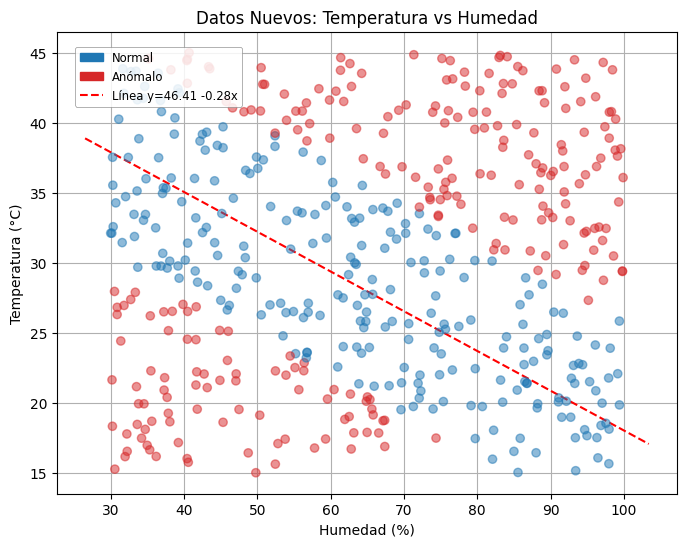

In [29]:
# Mapear colores discreto para que la leyenda sea clara
color_map = {False: 'tab:blue', True: 'tab:red'}
colors = df_datos_nuevos['es_anomalo'].map(color_map)

# Graficar
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(df_datos_nuevos['humedad'], df_datos_nuevos['temperatura'], c=colors, marker='o', alpha=0.5, zorder=3)
ax.grid(zorder=1)
ax.set_xlabel('Humedad (%)')
ax.set_ylabel('Temperatura (°C)')
ax.set_title('Datos Nuevos: Temperatura vs Humedad')

# Añadir la línea de regresión
try:
    x_min, x_max = ax.get_xlim()
    new_x_vals = np.linspace(x_min, x_max, 100)
    new_y_vals = coefs[0] + coefs[1] * new_x_vals
    line_handle, = plt.plot(new_x_vals, new_y_vals, color='red', label='Línea y={:.2f} {:.2f}x'.format(coefs[0], coefs[1]), linestyle='--')
    a = 0
except Exception:
    # Si no existen, no hacer nad
    pass

# Crear handles para la leyenda (discretos: Normal vs Anómalo)
handles = [mpatches.Patch(color=color_map[False], label='Normal'), mpatches.Patch(color=color_map[True], label='Anómalo')]

if 'line_handle' in locals():
    handles.append(line_handle)

# Colocar la leyenda dentro del plot en una esquina con fondo semitransparente
legend = ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize='small', framealpha=0.85, edgecolor='gray')

# Hacer que la leyenda no tape completamente los puntos: disminuir alfa de la caja y usar marco
legend.get_frame().set_linewidth(0.5)

plt.show()

# Punto 2

In [30]:
df_datos_toy = pd.read_csv('data/datosToy.txt', header=None, sep=r'\s+', names=['x','y'])
df_datos_toy.head()

,x,y
0,-1.000000,18.966314
1,-0.997998,20.079921
2,-0.995996,18.209926
3,-0.993994,18.934774
4,-0.991992,18.512598


In [31]:
def coefs_optimos_L2(regData, degree):

    # Extraer las variables X e Y
    X = regData['x']
    Y = regData['y']   

    # Crear la matriz de diseño para un polinomio de grado 'degree'
    H = np.column_stack([X**i for i in range(degree + 1)])

    # Calcular los coeficientes óptimos beta
    beta = np.linalg.inv(H.T @ H) @ H.T @ Y
    return beta

In [32]:
# asumiendo relación 𝑦=𝛽0+𝛽1𝑥
coefs_toy = coefs_optimos_L2(df_datos_toy, degree=1)
print("Coeficientes óptimos beta:", coefs_toy)

Coeficientes óptimos beta: [ 6.34661676 -5.24801009]


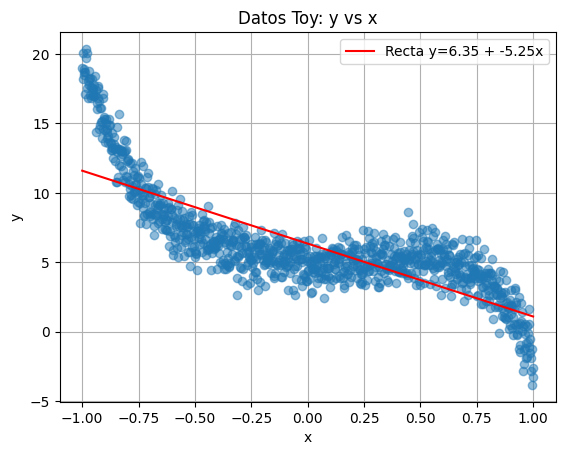

In [36]:
fig, ax = plt.subplots()
ax.scatter(df_datos_toy['x'], df_datos_toy['y'], marker='o', alpha=0.5, zorder=2)
# Generar valores para la línea de regresión
x_vals = np.linspace(df_datos_toy['x'].min(), df_datos_toy['x'].max(), 100)
y_vals = coefs_toy[0] + coefs_toy[1] * x_vals
ax.plot(x_vals, y_vals, color='red', label='Recta y={:.2f} + {:.2f}x'.format(coefs_toy[0], coefs_toy[1]), zorder=3)
ax.set_title('Datos Toy: y vs x')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(zorder=1)
plt.show()

In [37]:
# asumiendo relación 𝑦=𝛽0+𝛽1𝑥+𝛽2𝑥^2
coefs_toy = coefs_optimos_L2(df_datos_toy, degree=2)
print("Coeficientes óptimos beta:", coefs_toy)

Coeficientes óptimos beta: [ 5.05802404 -5.24801009  3.85805433]


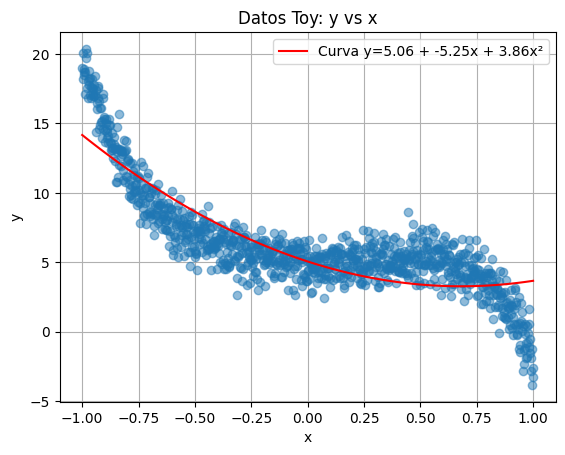

In [39]:
fig, ax = plt.subplots()
ax.scatter(df_datos_toy['x'], df_datos_toy['y'], marker='o', alpha=0.5, zorder=2)
# Generar valores para la curva de regresión polinómica de grado 2  
x_vals = np.linspace(df_datos_toy['x'].min(), df_datos_toy['x'].max(), 100)
y_vals = coefs_toy[0] + coefs_toy[1] * x_vals + coefs_toy[2] * x_vals**2
ax.plot(x_vals, y_vals, color='red', label='Curva y={:.2f} + {:.2f}x + {:.2f}x²'.format(coefs_toy[0], coefs_toy[1], coefs_toy[2]), zorder=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Datos Toy: y vs x')
ax.legend()
ax.grid(zorder=1)
plt.show()

In [40]:
# asumiendo relación 𝑦=𝛽0+𝛽1𝑥+𝛽2𝑥^2+𝛽3𝑥^3
coefs_toy = coefs_optimos_L2(df_datos_toy, degree=3)
print("Coeficientes óptimos beta:", coefs_toy)

Coeficientes óptimos beta: [  5.05802404   1.31770832   3.85805433 -10.92101471]


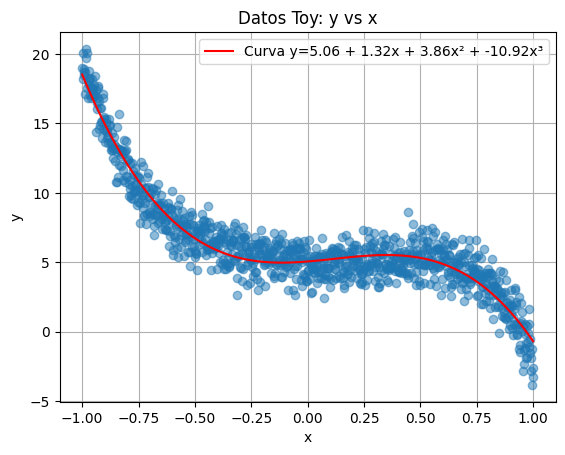

In [41]:
fig, ax = plt.subplots()
ax.scatter(df_datos_toy['x'], df_datos_toy['y'], marker='o', alpha=0.5, zorder=2)
# Generar valores para la curva de regresión polinómica
x_vals = np.linspace(df_datos_toy['x'].min(), df_datos_toy['x'].max(), 100)
y_vals = coefs_toy[0] + coefs_toy[1] * x_vals + coefs_toy[2] * x_vals**2 + coefs_toy[3] * x_vals**3
ax.plot(x_vals, y_vals, color='red', label='Curva y={:.2f} + {:.2f}x + {:.2f}x² + {:.2f}x³'.format(coefs_toy[0], coefs_toy[1], coefs_toy[2], coefs_toy[3]), zorder=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Datos Toy: y vs x')
ax.legend()
ax.grid(zorder=1)
plt.show()

# Punto 3

In [43]:
df_datos_NN = pd.read_csv('data/datosNN.txt', header=None, sep=r'\s+', names=['x','y'])
df_datos_NN.head()

,x,y
0,-0.255102,1.300806
1,-1.994028,-1.636839
2,-1.122089,-1.174486
3,-0.447641,1.172960
4,0.897416,0.726926


In [44]:
def aplicar_regla_decision(x, w, b):
    """Aplica función logística para cada punto para clasificación binaria.

    Args:
        x (_type_):vector dos dimensional de características
        w (_type_): peso / pendiente
        b (_type_): corte / bias
        
    """
    denominador  = 1 + np.exp(-(w @ x + b))
    return 1 / denominador

In [45]:
# clasificación de los datos usando pesos y bias dados
w = np.array([-2.0, 1.0])
b = -1.0
y_pred = np.array([aplicar_regla_decision(xi, w, b) for xi in df_datos_NN[['x','y']].values])
df_datos_NN['probabilidad'] = y_pred
df_datos_NN['clase'] = df_datos_NN['probabilidad'] >= 0.5
df_datos_NN.head()

,x,y,probabilidad,clase
0,-0.255102,1.300806,0.692325,True
1,-1.994028,-1.636839,0.794329,True
2,-1.122089,-1.174486,0.517416,True
3,-0.447641,1.172960,0.744262,True
4,0.897416,0.726926,0.112256,False


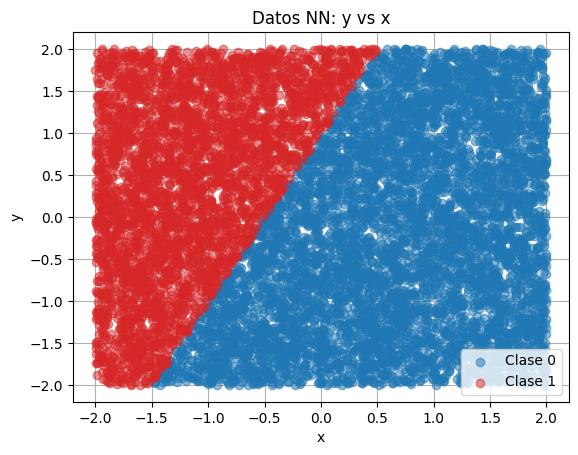

In [51]:
fig, ax = plt.subplots()

# 1. Graficar la Clase 0 (donde 'clase' es False)
# Filtrar solo los puntos de la Clase 0
df_clase_0 = df_datos_NN[df_datos_NN['clase'] == False]
ax.scatter(df_clase_0['x'], df_clase_0['y'], c='tab:blue', marker='o', alpha=0.5, zorder=3, label='Clase 0') #Etiqueta para la leyenda

# 2. Graficar la Clase 1 (donde 'clase' es True)
# Filtrar solo los puntos de la Clase 1
df_clase_1 = df_datos_NN[df_datos_NN['clase'] == True]
ax.scatter(df_clase_1['x'], df_clase_1['y'], c='tab:red', marker='o', alpha=0.5, zorder=3, label='Clase 1') # Etiqueta para la leyenda

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Datos NN: y vs x')

# 3. Llamar a legend() sin argumentos para usar las etiquetas asignadas
ax.legend() 

ax.grid(zorder = 1)
plt.show()

# Punto 4

`redes neuronales`

# Punto 5

In [53]:
df_coordenadas_pacientes = pd.read_csv('data/coordenadasPacientes.txt', header=None, sep=r'\s+', names=['latitud','longitud'])
df_coordenadas_pacientes.head()

,latitud,longitud
0,3.215775,5.853221
1,4.486974,6.199002
2,2.980549,9.141662
3,5.253936,5.998349
4,3.432972,6.490219


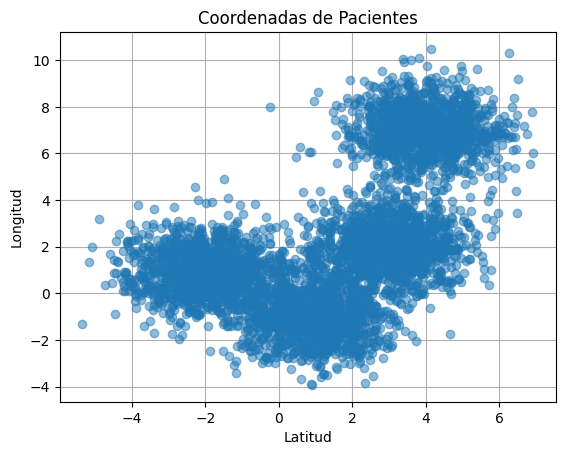

In [65]:
fig, ax = plt.subplots()
ax.scatter(df_coordenadas_pacientes['latitud'], df_coordenadas_pacientes['longitud'], marker='o', alpha=0.5, zorder=2)
ax.set_xlabel('Latitud')
ax.set_ylabel('Longitud')
ax.set_title('Coordenadas de Pacientes')
ax.grid(zorder=1)   
plt.show()

In [ ]:
# clasificación de datos con sci-kit-learn
kmeans = KMeans(n_clusters=4, init='random').fit(df_coordenadas_pacientes[['latitud','longitud']].values)
df_coords = df_coordenadas_pacientes.copy()
df_coords['clase'] = kmeans.labels_
# Obtener los centroides
centroides = kmeans.cluster_centers_

df_coords.head()

,latitud,longitud,clase
0,3.215775,5.853221,2
1,4.486974,6.199002,2
2,2.980549,9.141662,2
3,5.253936,5.998349,2
4,3.432972,6.490219,2


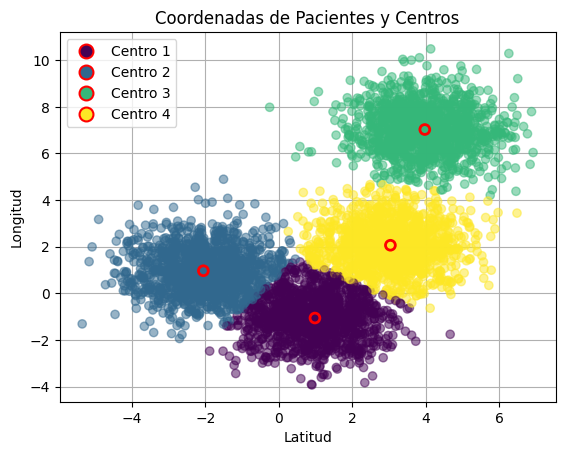

In [ ]:
# graficar el cluster al que pertenece cada punto
fig, ax = plt.subplots()

# Graficar los puntos con scatter (esto genera un ScalarMappable para los colores)
scatter = ax.scatter(df_coords['latitud'], df_coords['longitud'], 
                     c=df_coords['clase'], marker='o', alpha=0.5, zorder=2)

# Dibujar los centroides
ax.scatter(centroides[:, 0], centroides[:, 1], 
          c=range(4), marker='o', s=50, edgecolors='red', 
          linewidths=2, zorder=3)

# Crear la leyenda
handles = []
labels = []
for i in range(4):
    # Obtener el color correspondiente a cada cluster
    color = scatter.cmap(scatter.norm(i))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, markersize=10, 
                             markeredgecolor='red', markeredgewidth=1.5))
    labels.append(f'Centro {i+1}')

ax.legend(handles, labels, loc='best')

ax.set_title('Coordenadas de Pacientes y Centros de Atención')
ax.set_xlabel('Latitud')
ax.set_ylabel('Longitud')
ax.grid(zorder=1)  
plt.show()

In [79]:
kmeans = KMeans(n_clusters=4, random_state=42, init='random').fit(df_coordenadas_pacientes[['latitud','longitud']].values)
df_coords = df_coordenadas_pacientes.copy()
df_coords['clase'] = kmeans.labels_
# Obtener los centroides
centroides = kmeans.cluster_centers_

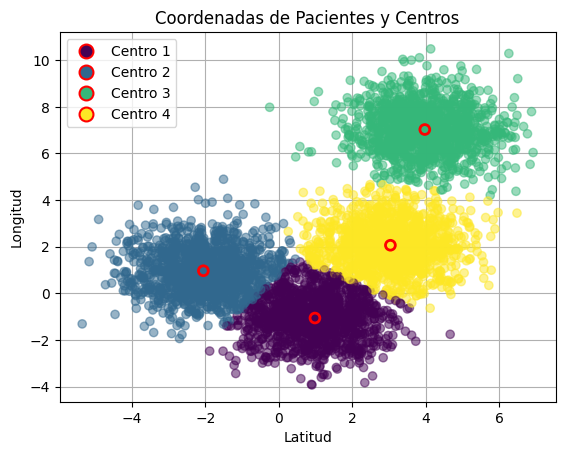

In [ ]:
# graficar el cluster al que pertenece cada punto
fig, ax = plt.subplots()

# Graficar los puntos con scatter (esto genera un ScalarMappable para los colores)
scatter = ax.scatter(df_coords['latitud'], df_coords['longitud'], 
                     c=df_coords['clase'], marker='o', alpha=0.5, zorder=2)

# Dibujar los centroides
ax.scatter(centroides[:, 0], centroides[:, 1], 
          c=range(4), marker='o', s=50, edgecolors='red', 
          linewidths=2, zorder=3)

# Crear la leyenda
handles = []
labels = []
for i in range(4):
    # Obtener el color correspondiente a cada cluster
    color = scatter.cmap(scatter.norm(i))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, markersize=10, 
                             markeredgecolor='red', markeredgewidth=1.5))
    labels.append(f'Centro {i+1}')

ax.legend(handles, labels, loc='best')

ax.set_title('Coordenadas de Pacientes y Centros de Atención')
ax.set_xlabel('Latitud')
ax.set_ylabel('Longitud')
ax.grid(zorder=1)  
plt.show()